<a href="https://colab.research.google.com/github/rybinsky/TimeSeries/blob/main/StoreSales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from datetime import datetime
import typing as tp

from IPython.display import display
from pylab import rcParams
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
)
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit

#import xgboost
#from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from statsmodels.tsa.seasonal import seasonal_decompose, STL


rcParams["figure.figsize"] = 15, 7

sns.set(palette="Set2", font_scale=1.3)
home_dir = '/content/drive/MyDrive/StoreSales'

In [ ]:
from warnings import filterwarnings

filterwarnings("ignore")

In [ ]:
train = pd.read_csv(f'{home_dir}/train.csv', parse_dates=['date'])
stores = pd.read_csv(f'{home_dir}/stores.csv')
oil = pd.read_csv(f'{home_dir}/oil.csv', parse_dates=['date'])
holidays_events = pd.read_csv(f'{home_dir}/holidays_events.csv', parse_dates=['date'])

In [ ]:
test = pd.read_csv(f'{home_dir}/test.csv', parse_dates=['date'])

In [ ]:
train.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [ ]:
train.shape, train.columns

((3000888, 6),
 Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion'], dtype='object'))

In [ ]:
stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [ ]:
stores.shape, stores.columns

((54, 5),
 Index(['store_nbr', 'city', 'state', 'type', 'cluster'], dtype='object'))

In [ ]:
oil.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [ ]:
oil.shape, oil.columns

((1218, 2), Index(['date', 'dcoilwtico'], dtype='object'))

In [ ]:
holidays_events.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [ ]:
holidays_events.shape, holidays_events.columns

((350, 6),
 Index(['date', 'type', 'locale', 'locale_name', 'description', 'transferred'], dtype='object'))

In [ ]:
train = train.merge(stores, on = 'store_nbr')
train = train.merge(oil, on = 'date', how = 'left')
holidays_events = holidays_events.rename(columns = {'type': 'holiday_type'})
train = train.merge(holidays_events, on = 'date', how = 'left')

In [ ]:
train.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,dcoilwtico,holiday_type,locale,locale_name,description,transferred
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False


In [ ]:
train.shape

(3054348, 16)

In [ ]:
train['dcoilwtico'].fillna(method = 'ffill', inplace = True)
train['transferred'].fillna(False, inplace = True)
train['onpromotion'].fillna(False, inplace = True)

train['day'] = train['date'].dt.day
train['month'] = train['date'].dt.month
train['year'] = train['date'].dt.year
train['day_of_week'] = train['date'].dt.dayofweek
train['is_weekend'] = train['day_of_week'].isin([5, 6])

In [ ]:
unique_ts = len(np.unique(train['store_nbr'])) * len(np.unique(train['family']))

print('Number of unique time series (stores * families): ' + str(unique_ts))

Number of unique time series (stores * families): 1782


In [ ]:
np.unique(train['family'])

array(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
       'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI', 'EGGS',
       'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HARDWARE',
       'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES',
       'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN', 'LINGERIE',
       'LIQUOR,WINE,BEER', 'MAGAZINES', 'MEATS', 'PERSONAL CARE',
       'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'POULTRY',
       'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES',
       'SEAFOOD'], dtype=object)

In [ ]:
#Choose smaller df
df = train[(train['store_nbr'] == 10) & (train['family'] == 'PERSONAL CARE')]

In [ ]:
df.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,...,holiday_type,locale,locale_name,description,transferred,day,month,year,day_of_week,is_weekend
56587,58,2013-01-01,10,PERSONAL CARE,0.0,0,Quito,Pichincha,C,15,...,Holiday,National,Ecuador,Primer dia del ano,False,1,1,2013,1,False
56620,1840,2013-01-02,10,PERSONAL CARE,223.0,0,Quito,Pichincha,C,15,...,NaN,NaN,NaN,NaN,False,2,1,2013,2,False
56653,3622,2013-01-03,10,PERSONAL CARE,169.0,0,Quito,Pichincha,C,15,...,NaN,NaN,NaN,NaN,False,3,1,2013,3,False
56686,5404,2013-01-04,10,PERSONAL CARE,119.0,0,Quito,Pichincha,C,15,...,NaN,NaN,NaN,NaN,False,4,1,2013,4,False
56719,7186,2013-01-05,10,PERSONAL CARE,270.0,0,Quito,Pichincha,C,15,...,Work Day,National,Ecuador,Recupero puente Navidad,False,5,1,2013,5,True


In [ ]:
#df = df.set_index("date")
test_size = 365
df_train = df.iloc[ : -test_size]
df_test = df.iloc[-test_size : ]

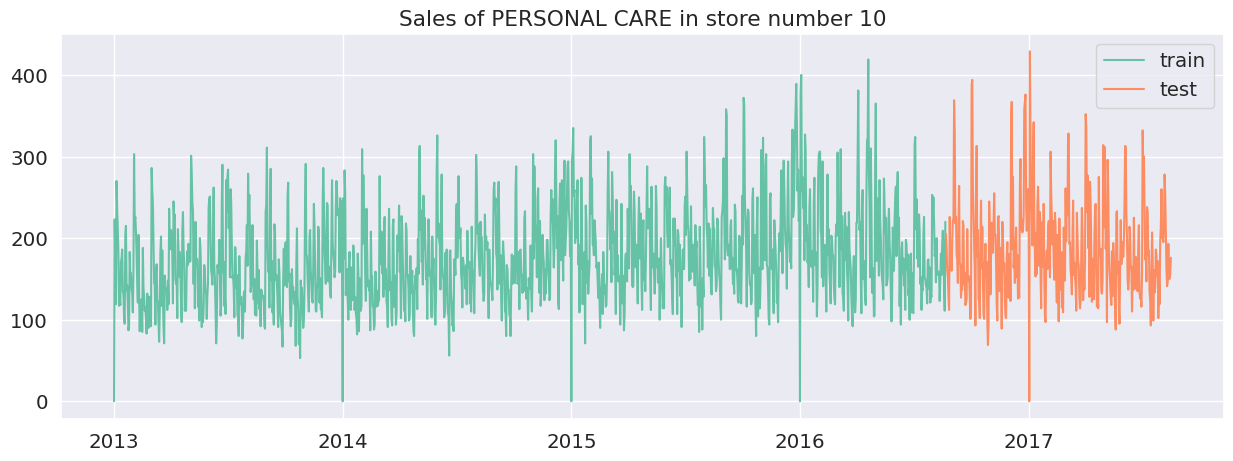

In [ ]:
plt.figure(figsize = (15, 5))
plt.title("Sales of PERSONAL CARE in store number 10")
plt.plot(df_train.index, df_train['sales'].reset_index(drop = True), label="train")
plt.plot(df_test.index, df_test['sales'].reset_index(drop = True), label="test")
plt.legend();

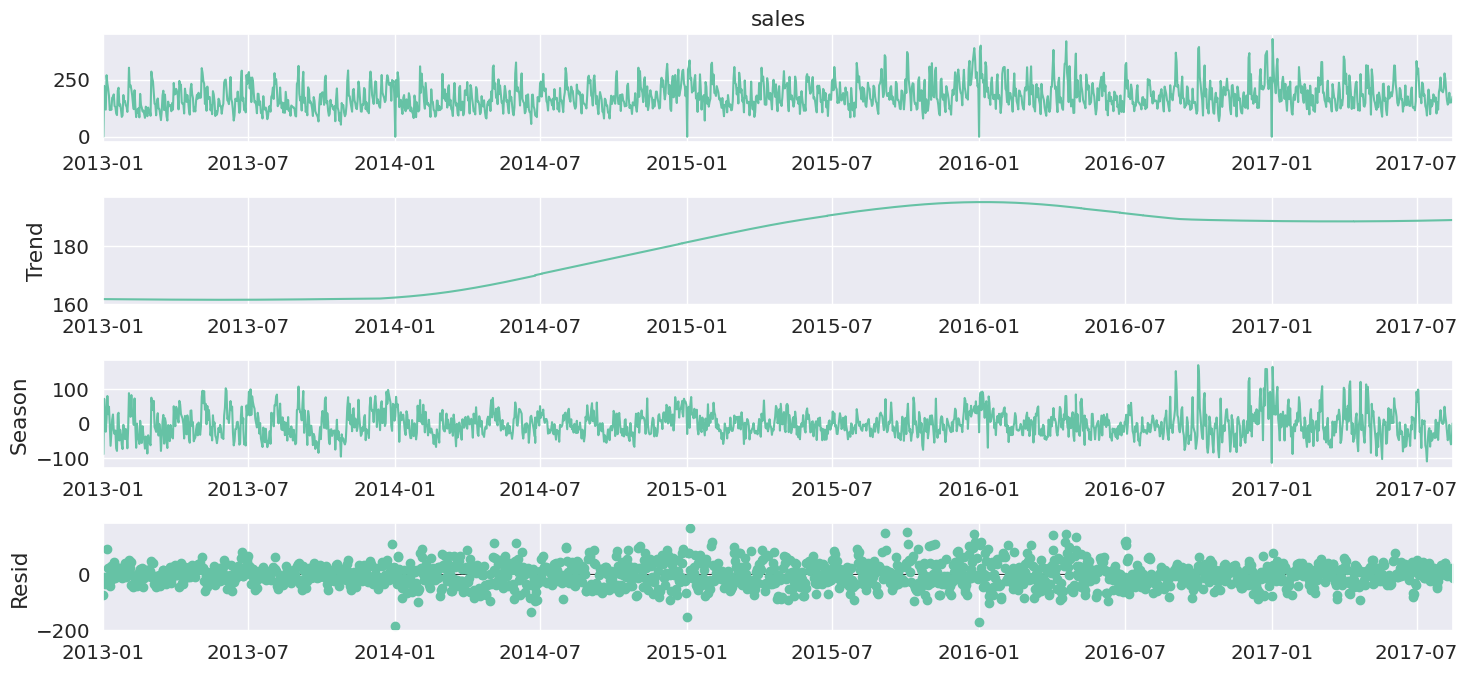

In [ ]:
result = STL(df['sales'], period = 365).fit()
result.plot();

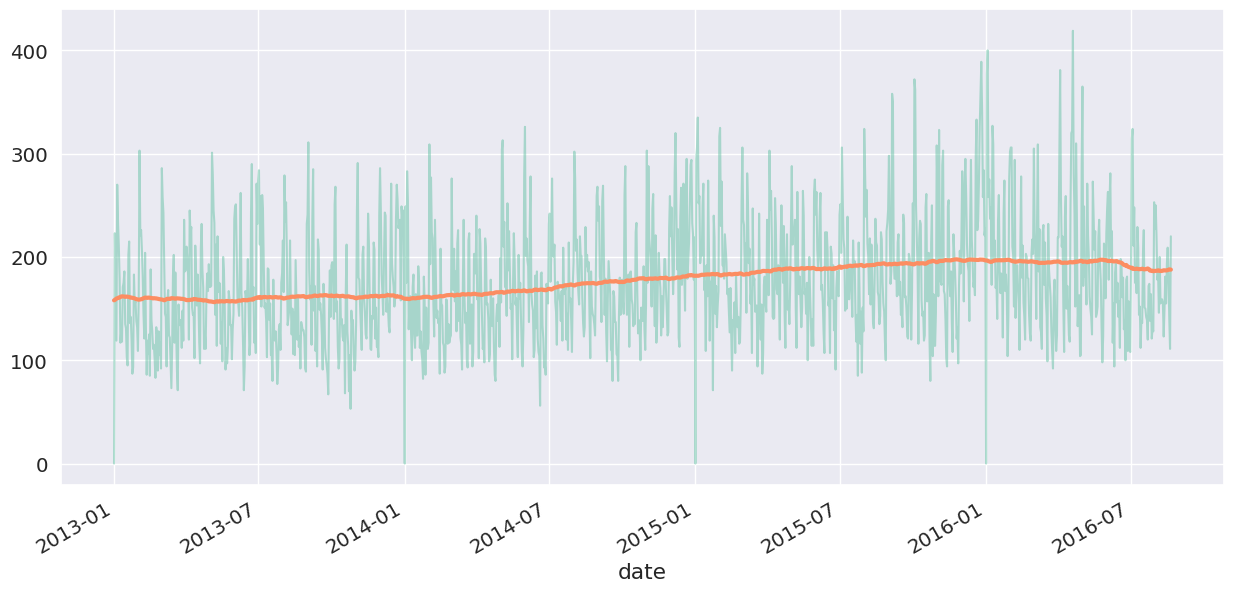

In [ ]:
trend = df_train['sales'].rolling(
    window = 365,
    center = True,
    min_periods = 183,
).mean()

ax = df_train['sales'].plot(alpha = 0.5)
ax = trend.plot(ax = ax, linewidth = 3)

In [196]:
from statsmodels.tsa.deterministic import DeterministicProcess

y = df_train.sales.copy()  # the target
y_test = df_test.sales.copy()

dp = DeterministicProcess(
    index = df.sales.index,  # dates from the training data
    order = 2,             # the time dummy (trend)
)

# YOUR CODE HERE: Create the feature set for the dates given in y.index
X = dp.in_sample()
# YOUR CODE HERE: Create features for a 90-day forecast.
X_fore = X[-test_size : ]
X = X[: -test_size]

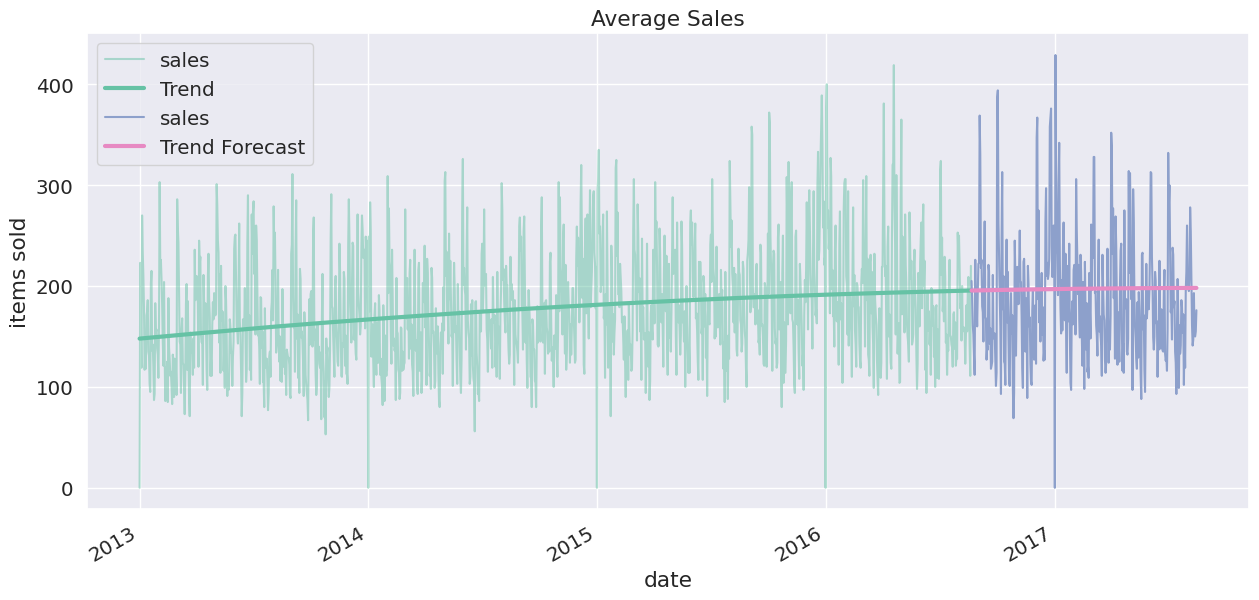

In [197]:
model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

ax = y.plot(alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, linewidth=3, label="Trend", color='C0')
ax = y_test.plot(ax=ax, label="sales", color='C2')
ax = y_fore.plot(ax=ax, linewidth=3, label="Trend Forecast", color='C3')
ax.legend();